In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [4]:
df=pd.read_csv("amz_uk_price_prediction_dataset.csv")
df.head()


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [5]:
df.dtypes

uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isBestSeller            bool
boughtInLastMonth      int64
category              object
dtype: object

# Part 1: Analyzing Best-Seller Trends Across Product Categories

In [6]:
# Create a crosstab between the product category and the isBestSeller status.

crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])


In [20]:
# Are there categories where being a best-seller is more prevalent?

mask = (crosstab_result[True] > crosstab_result[False])
crosstab_result[mask]

# Hint: one option is to calculate the proportion of best-sellers for each category
# then sort the categories based on this proportion in descending order.

top_five =crosstab_result.sort_values(by=True, ascending=False)[:6]
top_five

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
Beauty,19010,302


In [30]:
# Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value # p <0. 05 so there is a relationship

(36540.20270061387, 0.0)

In [31]:
# Compute Cramér's V to understand the strength of association between best-seller status and category.

from scipy.stats.contingency import association

association(crosstab_result, method="cramer") #weak association

0.1222829439760564

<Axes: xlabel='category'>

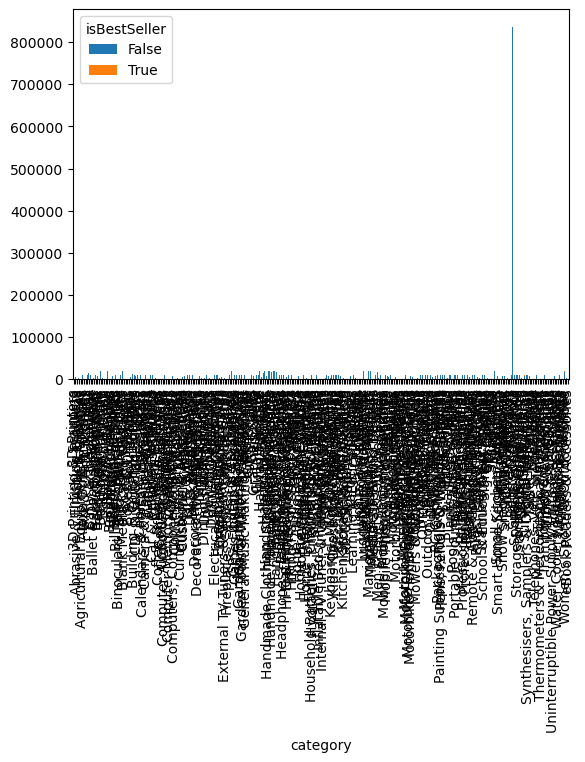

In [39]:
# Visualize the relationship between product categories and the best-seller status using a stacked bar chart

crosstab_result.plot(kind="bar", stacked=True)

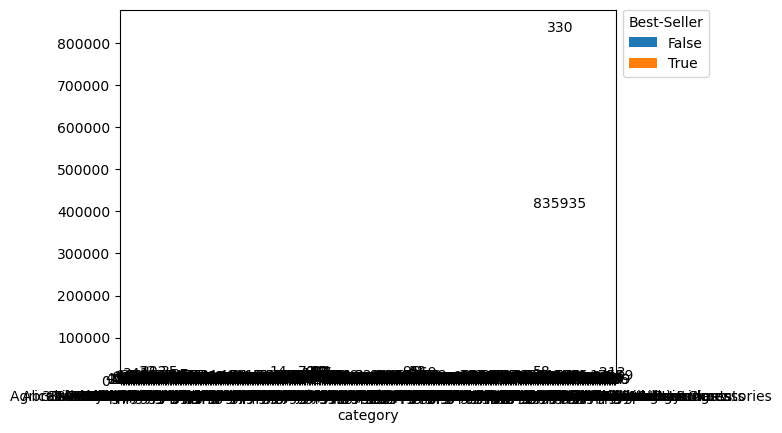

In [42]:
# Créer le diagramme en bâtons
ax = crosstab_result.plot(kind='bar', stacked=True, rot=0)

# Ajouter une légende
ax.legend(title='Best-Seller', bbox_to_anchor=(1, 1.02), loc='upper left')

# Ajouter des annotations si nécessaire
for c in ax.containers:
    ax.bar_label(c, label_type='center')

# Afficher le diagramme
plt.show()

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [51]:
# Preliminary Step: Remove outliers in product prices.

# For this purpose, we can use the IQR (Interquartile Range) method. 
# Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR 
# will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

# Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis on how to do this.

def prices_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

outliers = prices_test_outliers(df['price'])

#sorted_outliers = outliers.sort_values(ascending=False)

print(sorted_outliers)

2008013    100000.00
1987238     77752.00
1905315     24674.59
1408966     23482.73
319555      22933.42
             ...    
1691277       100.00
1936643       100.00
175137        100.00
47043         100.00
1008532       100.00
Name: price, Length: 327688, dtype: float64


In [66]:
# Preliminary Step: Remove outliers in product prices.

df_excl_outliers = df['price'].drop(columns= outliers)
display((df_excl_outliers))

0          21.99
1          23.99
2          21.99
3          31.99
4          17.99
           ...  
2443646    22.34
2443647    97.99
2443648    52.99
2443649    79.99
2443650    53.99
Name: price, Length: 2443651, dtype: float64

In [61]:
# Visualizations:

# Use a violin plot to visualize the distribution of price across different product categories. 
# Filter out the top 20 categories based on count for better visualization.
# Which product category tends to have the highest median price? Don't filter here by top categories.. 

sns.violinplot(data=df, x='isBestSeller', y='df_excl_outliers', palette="coolwarm")

ValueError: Could not interpret input 'df_excl_outliers'

In [62]:
# Create a violin plot
sns.violinplot(data=df, x='isBestSeller', y='df_excl_outliers', palette="coolwarm")

plt.xlabel('Is Best Seller')
plt.ylabel('Price (Excluding Outliers)')
plt.title('Distribution of Prices for Best Sellers')
plt.show()

ValueError: Could not interpret input 'df_excl_outliers'

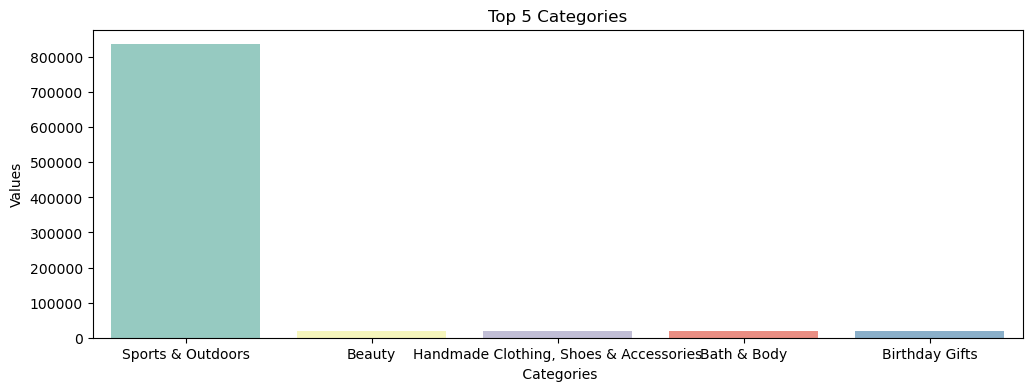

In [49]:
# Créez le bar chart
plt.figure(figsize=(12,4))  # Ajustez la taille du graphique selon vos préférences
sns.barplot(x=top_five.index, y=top_five.values, palette="Set3")

# Ajoutez des labels et un titre
plt.xlabel(" Categories")
plt.ylabel("Values")
plt.title("Top 5 Categories")

# Affichez le graphique
plt.show()

In [51]:
# For a subset of top categories, visualize their proportions using a pie chart. Does any category dominate the listings?

df['top_5_category'] = pd.qcut(df['category'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df['top_5_category']

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Axes: ylabel='count'>

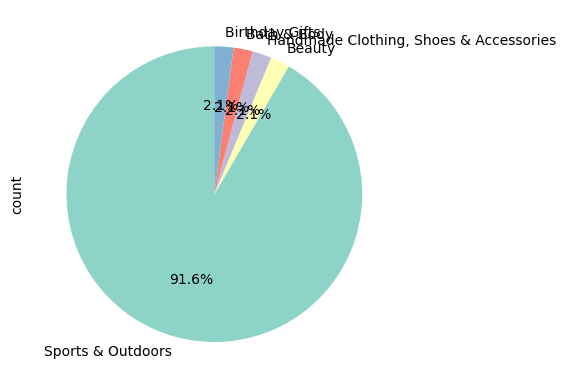

In [44]:
top_five.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))

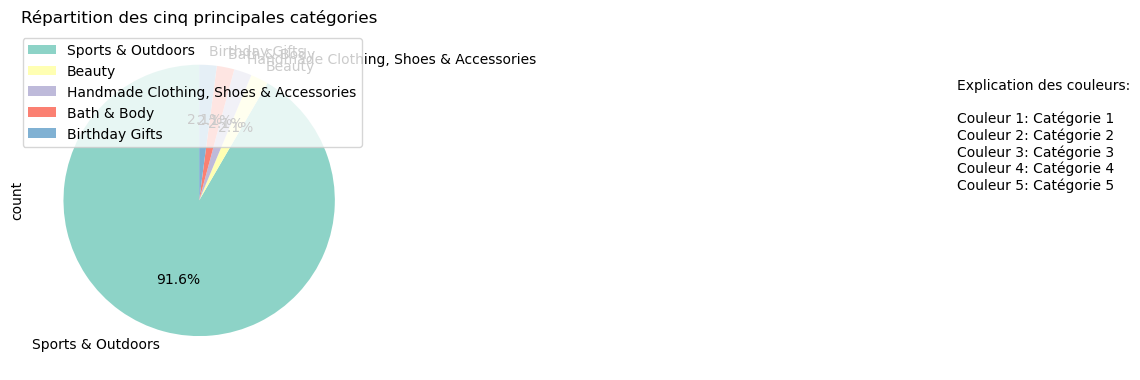

In [52]:
# Créer le diagramme à secteurs
plt.figure(figsize=(8, 8))
top_five.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))

# Ajouter la légende
plt.legend(labels=top_five.index, loc='upper right')

# Ajouter un titre
plt.title("Répartition des cinq principales catégories")

# Ajouter une explication des couleurs
plt.text(1.2, 0.5, "Explication des couleurs:\n\nCouleur 1: Catégorie 1\nCouleur 2: Catégorie 2\nCouleur 3: Catégorie 3\nCouleur 4: Catégorie 4\nCouleur 5: Catégorie 5", fontsize=10, transform=plt.gcf().transFigure)

# Afficher le diagramme
plt.tight_layout()
plt.show()


In [17]:
# 1.Measures of Centrality:

# Calculate the mean, median, and mode for the price of products.

df['price'].describe()


count    2.443651e+06
mean     8.924381e+01
std      3.456089e+02
min      0.000000e+00
25%      9.990000e+00
50%      1.909000e+01
75%      4.599000e+01
max      1.000000e+05
Name: price, dtype: float64

In [58]:
mode = df['price'].mode()
median = df['price'].median()

mode

(0    9.99
 Name: price, dtype: float64,
 19.09)

In [13]:
#average price point of products listed? How does this compare with the most common price point (mode)?

frequency_table = df['price'].value_counts()
frequency_table

price
9.99       48922
12.99      38823
8.99       34058
7.99       33632
14.99      32570
           ...  
2398.99        1
1453.08        1
1785.63        1
1347.36        1
317.34         1
Name: count, Length: 82916, dtype: int64

In [21]:
#2. Measures of Dispersion:

# Determine the variance, standard deviation, range, and interquartile range for product price
std_dev_price = df['price'].std()
variance_price = df['price'].var()
range_price = df['price'].max() - df['price'].min()
interquartile_range = df['price'].quantile(0.75) - df['price'].quantile(0.25)


std_dev_price, variance_price, range_price, interquartile_range

(345.60886175352226, 119445.48532256528, 100000.0, 36.0)

In [ ]:
# How varied are the product prices? Are there any indicators of a significant spread in prices?

In [54]:
# 1. Calculate the mean, median, and mode for the rating of products.

rating = df['stars'].describe()

#How do customers generally rate products? Is there a common trend?
rating, rating.value_counts

(count    2.443651e+06
 mean     2.152836e+00
 std      2.194865e+00
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      4.400000e+00
 max      5.000000e+00
 Name: stars, dtype: float64,
 <bound method IndexOpsMixin.value_counts of count    2.443651e+06
 mean     2.152836e+00
 std      2.194865e+00
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      4.400000e+00
 max      5.000000e+00
 Name: stars, dtype: float64>)